### Quickstart Tutorial: Using the `ohana` Predictor

This notebook demonstrates the standard, high-level way to run anomaly detection using the `ohana` package. This is the recommended workflow for most use cases.

We will use the main `Predictor` class, which handles all the complex steps internally. The process is simple:
1.  Configure paths and settings.
2.  Initialize the `Predictor`.
3.  Run the `predict` method.
4.  Visualize the results.

##### Step 1: Imports and Configuration

First, we'll import the necessary classes and define the paths for our model, data, and output files.

In [1]:
import torch
import os
import json
import numpy as np
import sys

In [2]:
print(f"Setting PyTorch to use {os.cpu_count() or 8} threads.")
torch.set_num_threads(os.cpu_count() or 8)
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count() or 8)
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count() or 8)

Setting PyTorch to use 16 threads.


In [3]:
sys.path.insert(0, '../')

In [4]:
# Import the necessary classes from your ohana package
# !NOTE: Make sure the 'ohana' directory is in your Python path

from ohana.models.unet_3d import UNet3D
from ohana.predict.predictor import Predictor
from ohana.preprocessing.data_loader import DataLoader
from ohana.preprocessing.preprocessor import Preprocessor
from ohana.visualization.plotter import ResultVisualizer

In [5]:
""" Configuration """
# !NOTE: Replace these with the actual paths to your files.

# Path to the trained model
MODEL_PATH = "../trained_models/old_best_model_unet3d.pth"

# Path to the config file that was used for model training
CONFIG_PATH = "../configs/creator_config.yaml"

# Path to the exposure you want to run the predictions on
EXPOSURE_PATH = "/Volumes/jwst/ilongo/raw_data/18220_Euclid_SCA/ap30_100k_0p8m0p3_fullnoi_E001_18220.fits"

# Path to where the processed exposure is saved to (MUST BE .NPY)
PROCESSED_EXPOSURE_FILE = 'tut_processed_ap30_100k_0p8m0p3_fullnoi_E001_18220.npy'

# Directory where model predictions will be stored
OUTPUT_DIR = "tut_prediction_outputs"

# Where processed exposure will be saved
PROCESSED_DATA_PATH = os.path.join(OUTPUT_DIR, PROCESSED_EXPOSURE_FILE)

# Where prediction mask with be saved
MASK_PATH = os.path.join(OUTPUT_DIR, 'prediction_mask.npy')

# Where detections will be saved
DETECTIONS_PATH = os.path.join(OUTPUT_DIR, 'detections.json')

In [6]:
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


##### Step 2: Run the Prediction

This is the core of the workflow. We create an instance of the `Predictor` class and call the `.predict()` method. The class will handle loading the model, preprocessing the data (and caching it), running inference, and finding objects.

In [7]:
"""Initialize the predictor"""
# This loads the model and sets up the configuration.
print("Initializing the predictor...")
predictor = Predictor(model_path=MODEL_PATH, config_path=CONFIG_PATH)

Initializing the predictor...
ReferencePixelCorrector initialized with x_opt=64, y_opt=4.
Preprocessor initialized. Reference pixel correction: Enabled.
Loading 3D U-Net model from: ../trained_models/old_best_model_unet3d.pth


In [25]:
"""Run the prediction"""
# The predict method handles the entire pipeline and saves the processed data cube.
print(f"Running prediction on {EXPOSURE_PATH}...")
anomalies = predictor.predict(
    exposure_path=EXPOSURE_PATH,
    processed_exposure_file=PROCESSED_DATA_PATH
)

Running prediction on /Volumes/jwst/ilongo/raw_data/18220_Euclid_SCA/ap30_100k_0p8m0p3_fullnoi_E001_18220.fits...

--- Analyzing exposure: /Volumes/jwst/ilongo/raw_data/18220_Euclid_SCA/ap30_100k_0p8m0p3_fullnoi_E001_18220.fits ---
Loading data from Multi-Extension FITS file: /Volumes/jwst/ilongo/raw_data/18220_Euclid_SCA/ap30_100k_0p8m0p3_fullnoi_E001_18220.fits


Loading FITS extensions: 100%|██████████| 450/450 [07:00<00:00,  1.07it/s]


Found existing processed file. Loading from: tut_prediction_outputs/tut_processed_ap30_100k_0p8m0p3_fullnoi_E001_18220.npy


Predicting Patches:   0%|          | 0/81 [00:00<?, ?it/s]/Users/ilongo/Desktop/Excalibur/ohana/jpl_env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Predicting Patches:   0%|          | 0/81 [00:18<?, ?it/s]


KeyboardInterrupt: 

In [9]:
"""Save the remaining results"""
# The predictor object now holds the final mask as an attribute.
if predictor.prediction_mask is not None:
    np.save(MASK_PATH, predictor.prediction_mask)
    print(f"Saved prediction mask to: {MASK_PATH}")

Saved prediction mask to: tut_prediction_outputs/prediction_mask.npy


In [10]:
with open(DETECTIONS_PATH, 'w') as f:
    json.dump(anomalies, f, indent=4)
    print(f"Saved anomaly list to: {DETECTIONS_PATH}")

print(f"\nPrediction complete! Found {len(anomalies)} anomalies.")

Saved anomaly list to: tut_prediction_outputs/detections.json

Prediction complete! Found 1365 anomalies.


##### Step 3: Visualize the Results

Now that the prediction is done and all output files are saved, we can use the `ResultVisualizer` to see the outcome.

Generating visualization...
Loading pre-processed data from: tut_prediction_outputs/tut_processed_ap30_100k_0p8m0p3_fullnoi_E001_18220.npy
Loading prediction mask from: tut_prediction_outputs/prediction_mask.npy
Loaded 1365 individual detections from tut_prediction_outputs/detections.json


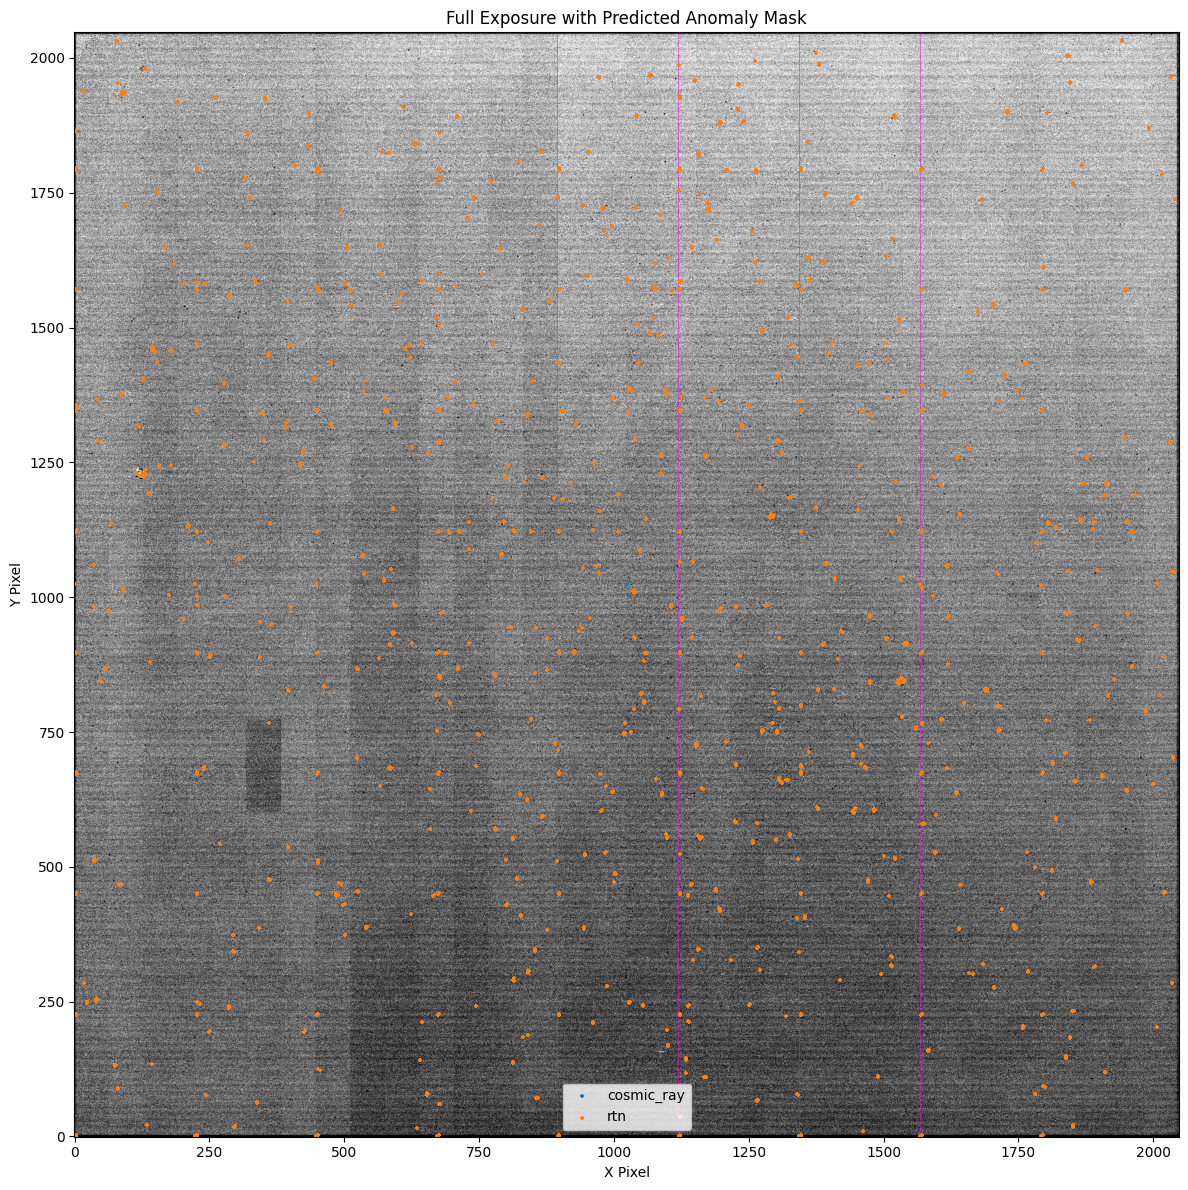

In [11]:
print("Generating visualization...")

# Initialize the visualizer with the paths to our saved results
visualizer = ResultVisualizer(
    processed_data_path=PROCESSED_DATA_PATH,
    prediction_mask_path=MASK_PATH
)

# Load the list of detected anomalies
visualizer.load_detection_list(results_path=DETECTIONS_PATH)

# Generate and display the plot
visualizer.plot_full_mask_overlay()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
diff_data_cube = np.load(PROCESSED_DATA_PATH)
diff_data_cube.shape

(449, 2048, 2048)

In [17]:
diff_data_cube[0][0]

array([-154., -120., -116., ..., -101., -115., -125.], dtype=float32)

In [23]:
y, x = 1, 226

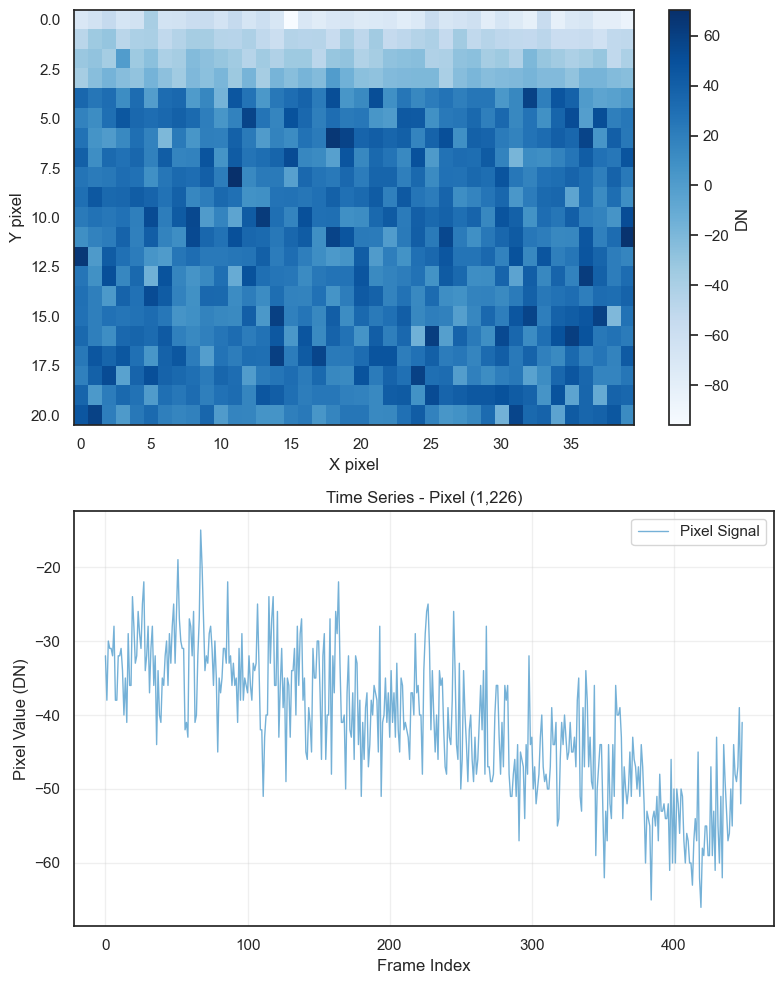

In [24]:
sns.set_theme(style="white", palette="Blues")
palette = sns.color_palette('Blues', 6)

# Create figure with 2 subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
sns.set_theme(style="white", palette="Blues")

# Extract region around event for spatial plot
radius = 20
y_start = max(0, y - radius)
y_end = min(diff_data_cube.shape[1], y + radius)
x_start = max(0, x - radius)
x_end = min(diff_data_cube.shape[2], x + radius)

# Use frame where event first appears
frame_idx = 400
region = diff_data_cube[frame_idx, y_start:y_end, x_start:x_end]

# Plot 1: Spatial image of the telegraph noise region
im = ax1.imshow(region, cmap='Blues', aspect='auto')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')

cbar = plt.colorbar(im, ax=ax1, label='DN')

# Plot 2: Time series of the telegraph noise pixel
# if 'time_series' in event:
#     time_series = event['time_series']
#     frames = np.arange(len(time_series))

# Plot the time series
time_series = diff_data_cube[:, y, x]
frames = np.arange(len(diff_data_cube))

ax2.plot(frames, time_series, linewidth=1, alpha=0.8, label='Pixel Signal', c = palette[3])

# # Add horizontal lines for high and low states if available
# if 'high_state_value' in event:
#     ax2.axhline(y=event['high_state_value'], 
#             linestyle='--', linewidth=2, alpha=0.7,
#             label=f"High: {event['high_state_value']:.1f} DN")
# if 'low_state_value' in event:
#     ax2.axhline(y=event['low_state_value'], 
#             linestyle='--', linewidth=2, alpha=0.7,
#             label=f"Low: {event['low_state_value']:.1f} DN")

ax2.set_xlabel('Frame Index')
ax2.set_ylabel('Pixel Value (DN)')
ax2.set_title(f'Time Series - Pixel ({y},{x})')
ax2.grid(True, alpha=0.3)
ax2.legend()
    
# else:
#     # If no time series data, extract it from diff_data_cube
#     pixel_time_series = diff_data_cube[:, y, x]
#     frames = np.arange(len(pixel_time_series))
    
#     ax2.plot(frames, pixel_time_series, 'b-', linewidth=1, alpha=0.8)
#     ax2.set_xlabel('Frame Index')
#     ax2.set_ylabel('Pixel Value (DN)')
#     ax2.set_title(f'Time Series - Pixel ({y},{x})')
#     ax2.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()